### Data from kaggle: https://www.kaggle.com/c/ghouls-goblins-and-ghosts-boo

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ghouls-goblins-and-ghosts-boo/train.csv.zip
/kaggle/input/ghouls-goblins-and-ghosts-boo/sample_submission.csv.zip
/kaggle/input/ghouls-goblins-and-ghosts-boo/test.csv.zip


In [2]:
# Import the required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lightgbm as lgb
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_data_orig = pd.read_csv('/kaggle/input/ghouls-goblins-and-ghosts-boo/train.csv.zip')
test_data_orig = pd.read_csv('/kaggle/input/ghouls-goblins-and-ghosts-boo/test.csv.zip')

In [4]:
train_data = train_data_orig.copy()
test_data = test_data_orig.copy()

In [5]:
train_data = train_data.drop(['id'], axis = 1)
test_data = test_data.drop(['id'], axis = 1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bone_length    371 non-null    float64
 1   rotting_flesh  371 non-null    float64
 2   hair_length    371 non-null    float64
 3   has_soul       371 non-null    float64
 4   color          371 non-null    object 
 5   type           371 non-null    object 
dtypes: float64(4), object(2)
memory usage: 17.5+ KB


In [6]:
train_data.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [7]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
bone_length,371.0,0.434160,0.132833,0.061032,0.340006,0.434891,0.517223,0.817001
rotting_flesh,371.0,0.506848,0.146358,0.095687,0.414812,0.501552,0.603977,0.932466
hair_length,371.0,0.529114,0.169902,0.134600,0.407428,0.538642,0.647244,1.000000
has_soul,371.0,0.471392,0.176129,0.009402,0.348002,0.466372,0.600610,0.935721


In [8]:
train_data['type'].value_counts()

Ghoul     129
Goblin    125
Ghost     117
Name: type, dtype: int64

In [9]:
train_data.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [10]:
def avg_col(data):
    a = data.groupby('color').count()['has_soul']
    c = a/(data.shape[0])
    v = pd.DataFrame(c.reset_index(name='count'))
    d = data[['color']]

    col = []
    for i in range(data.shape[0]):
        for n in range(c.shape[0]):
            if (d['color'][i] == v['color'][n]):
                col.append(v['count'][n]) 
    data['avg_color'] = col
    return data
train_data_avg = avg_col(train_data)
test_data_avg = avg_col(test_data)



train_data_avg.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,type,avg_color
0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul,0.323450
1,0.575560,0.425868,0.531401,0.439899,green,Goblin,0.113208
2,0.467875,0.354330,0.811616,0.791225,black,Ghoul,0.110512
3,0.776652,0.508723,0.636766,0.884464,black,Ghoul,0.110512
4,0.566117,0.875862,0.418594,0.636438,green,Ghost,0.113208


In [11]:
for i in range(test_data_avg.shape[0]):
    for n in range(train_data_avg.shape[0]):
        if (test_data_avg['color'][i] == train_data_avg['color'][n]):
            test_data_avg['avg_color'][i] = train_data_avg['avg_color'][n]

In [12]:
test_data_avg.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,avg_color
0,0.471774,0.387937,0.706087,0.698537,black,0.110512
1,0.427332,0.645024,0.565558,0.451462,white,0.369272
2,0.549602,0.491931,0.660387,0.449809,black,0.110512
3,0.638095,0.682867,0.471409,0.356924,white,0.369272
4,0.361762,0.583997,0.377256,0.276364,black,0.110512


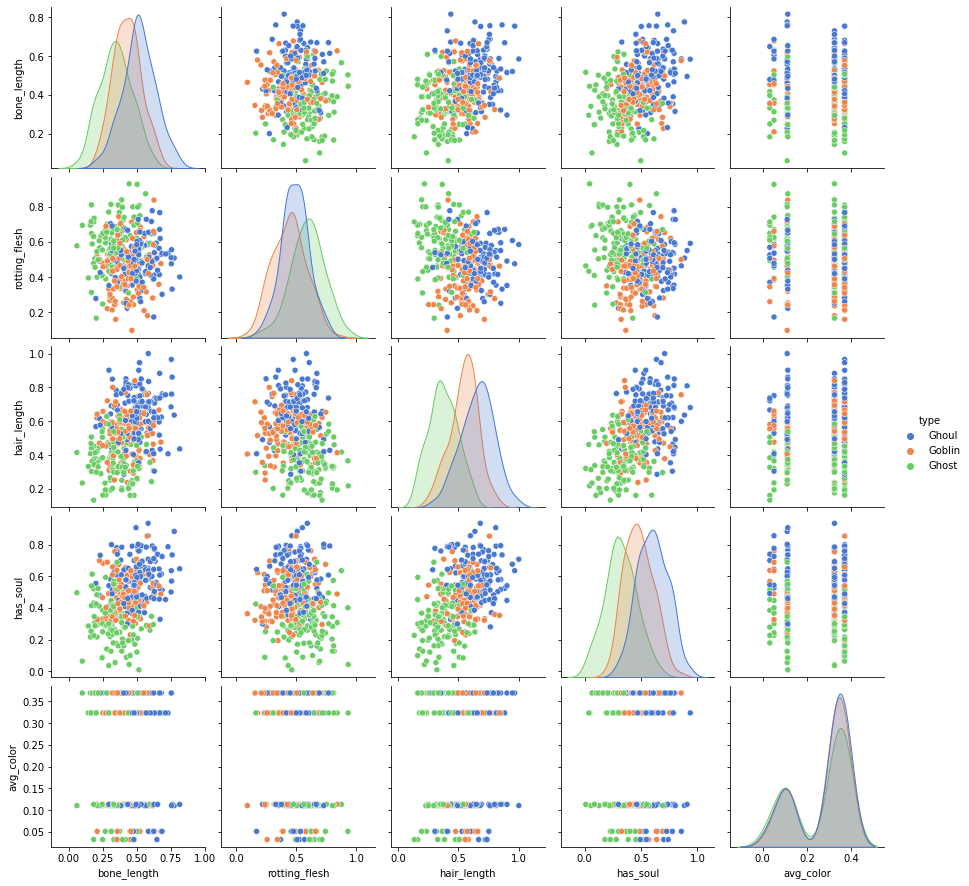

In [13]:
# color_le = preprocessing.LabelEncoder()
# color_le.fit(train_data_avg['color'])
# train_data_avg['color_int'] = color_le.transform(train_data_avg['color'])
_ = sns.pairplot(train_data_avg.drop('color', axis = 1), hue = 'type', palette = 'muted', diag_kind='kde')

# train_data_avg.drop('color_int', axis = 1, inplace = True)

ValueError: num must be 1 <= num <= 4, not 5

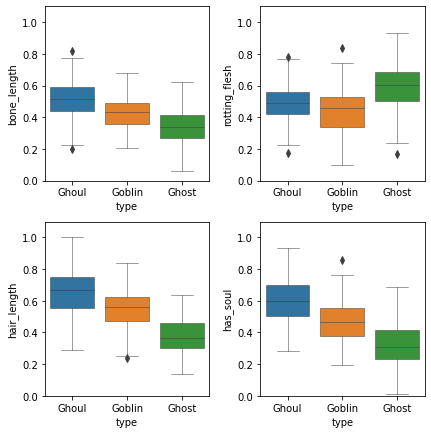

In [14]:
import matplotlib.pyplot as mp

data = train_data_avg.drop(['type','color'], axis=1)
data_type = train_data_avg['type']

fig, axes = mp.subplots(nrows=2, ncols=2, figsize=(6,6))
mp.tight_layout(w_pad=2.0, h_pad=2.0)

for i, column in zip(range(1,data.shape[1]+1), data.columns):
    mp.subplot(2,2,i)
    sns.boxplot(x=train_data_avg['type'], y=train_data_avg[column], linewidth=0.5)
    mp.ylabel(column)
    mp.ylim([0,1.1])

In [15]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=100, contamination = 0.1, random_state=20)
clf.fit(data)
predictions = clf.predict(data)
Xnew = data[predictions==1]
ynew = data_type[predictions==1]



In [16]:
train_data_wo_anom = pd.concat([Xnew, ynew], axis =1)
train_data_wo_anom.head()

,bone_length,rotting_flesh,hair_length,has_soul,avg_color,type
0,0.354512,0.350839,0.465761,0.781142,0.323450,Ghoul
1,0.575560,0.425868,0.531401,0.439899,0.113208,Goblin
5,0.405680,0.253277,0.441420,0.280324,0.113208,Goblin
6,0.399331,0.568952,0.618391,0.467901,0.369272,Goblin
7,0.516224,0.536429,0.612776,0.468048,0.323450,Ghoul


In [17]:
# def create_features(dataframe):
#     #Create some new variables.
#     dataframe['hair_soul'] = dataframe['hair_length'] * dataframe['has_soul']
#     dataframe['bone_soul'] = dataframe['bone_length'] * dataframe['has_soul']
#     dataframe['hair_bone'] = dataframe['hair_length'] * dataframe['bone_length']
#     dataframe['rotting_hair'] = dataframe['rotting_flesh'] * dataframe['hair_length']
#     dataframe['rotting_soul'] = dataframe['rotting_flesh'] * dataframe['has_soul']
    
# create_features(train_data_avg)
# create_features(test_data_avg)



In [18]:
from sklearn.cluster import KMeans

cl_train_data = train_data_wo_anom.drop(['type'], axis=1)
cl_test_data = test_data_avg.drop(['color'], axis=1)

kmeans = KMeans(n_clusters = 3,random_state=0)

kmeans.fit(cl_train_data)
train_data_after_cl = train_data_wo_anom.copy()
train_data_after_cl['cluster'] = kmeans.labels_

cl_test_data['cluster'] = kmeans.predict(cl_test_data)

test_data_after_cl = pd.concat([test_data_avg, cl_test_data['cluster']], axis=1)


In [19]:
# train_data_after_cl = pd.get_dummies(train_data_after_cl, columns=["color"], prefix=["color"])
# test_data_after_cl = pd.get_dummies(test_data_after_cl, columns=["color"], prefix=["color"])
# remove_indexes = ["color", "hair_length", "has_soul", "rotting_flesh"]
# test_data_after_cl = test_data_after_cl.drop(remove_indexes, axis=1)


In [20]:
test_data_after_cl.head()

,bone_length,rotting_flesh,hair_length,has_soul,color,avg_color,cluster
0,0.471774,0.387937,0.706087,0.698537,black,0.110512,1
1,0.427332,0.645024,0.565558,0.451462,white,0.369272,0
2,0.549602,0.491931,0.660387,0.449809,black,0.110512,1
3,0.638095,0.682867,0.471409,0.356924,white,0.369272,0
4,0.361762,0.583997,0.377256,0.276364,black,0.110512,0


In [21]:
train_data_after_cl.head()

,bone_length,rotting_flesh,hair_length,has_soul,avg_color,type,cluster
0,0.354512,0.350839,0.465761,0.781142,0.323450,Ghoul,1
1,0.575560,0.425868,0.531401,0.439899,0.113208,Goblin,2
5,0.405680,0.253277,0.441420,0.280324,0.113208,Goblin,2
6,0.399331,0.568952,0.618391,0.467901,0.369272,Goblin,1
7,0.516224,0.536429,0.612776,0.468048,0.323450,Ghoul,1


In [22]:
train_data_after_cl = train_data_after_cl.drop(['type'], axis=1)

In [23]:
test_data_after_cl = test_data_after_cl.drop(['color'], axis=1)

In [24]:
# X = train_data_after_cl.drop(remove_indexes + ['type'], axis=1)

y = pd.DataFrame()
le = LabelEncoder()
le.fit(ynew)
y['type'] = le.fit_transform(ynew.values)



In [25]:
sc = StandardScaler()

feat   = sc.fit_transform(data.values)
feat

NameError: name 'StandardScaler' is not defined

In [26]:

from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaler = StandardScaler()
train_data_after_cl = scaler.fit_transform(train_data_after_cl.values)
test_data_after_cl = scaler.transform(test_data_after_cl)

X = train_data_after_cl

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.2)

KNeighborsClassifier
****Results****
Accuracy: 73.1343%
Log Loss: 7.939098143290699
SVC
****Results****
Accuracy: 73.1343%
Log Loss: 0.5986395753772594
DecisionTreeClassifier
****Results****
Accuracy: 58.2090%
Log Loss: 14.43411550832088
RandomForestClassifier
****Results****
Accuracy: 68.6567%
Log Loss: 0.6404360556819639
AdaBoostClassifier
****Results****
Accuracy: 71.6418%
Log Loss: 0.8907007429950996
GradientBoostingClassifier
****Results****
Accuracy: 70.1493%
Log Loss: 0.8096181284486468
GaussianNB
****Results****
Accuracy: 74.6269%
Log Loss: 0.7067628153125963
LinearDiscriminantAnalysis
****Results****
Accuracy: 76.1194%
Log Loss: 0.6081531277500585
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 70.1493%
Log Loss: 0.7501334953151403


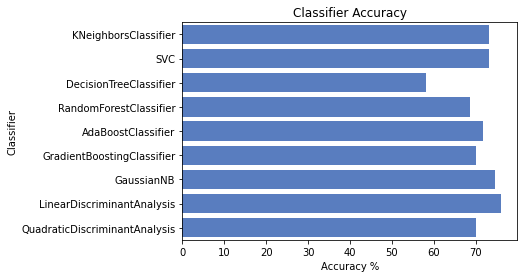

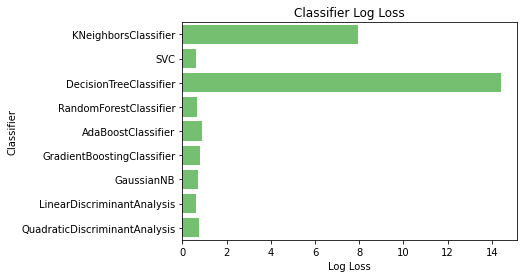

In [28]:
from matplotlib import pyplot as plt
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


#Build ten classifiers
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=1, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    print("="*30)
    print(name)

    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))

    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)

print("="*30)
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

In [29]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print(clf.score(X_test, y_test))
y_pred = clf.predict(test_data_after_cl)

0.7164179104477612


In [30]:
dt_clf = DecisionTreeClassifier(random_state = 0)
dt_clf.fit(X_train, y_train)
y_pred_test = dt_clf.predict(X_test)
y_pred = dt_clf.predict(test_data_after_cl)

print(metrics.classification_report(y_test, y_pred_test))
print("\nAccuracy Score is: " + str(metrics.accuracy_score(y_test, y_pred_test)))




              precision    recall  f1-score   support

           0       0.79      0.68      0.73        22
           1       0.67      0.55      0.60        22
           2       0.43      0.57      0.49        23

    accuracy                           0.60        67
   macro avg       0.63      0.60      0.61        67
weighted avg       0.63      0.60      0.61        67


Accuracy Score is: 0.5970149253731343


In [31]:
params = {'n_estimators':[10, 20, 50, 100], 'criterion':['gini', 'entropy'], 'max_depth':[None, 5, 10, 25, 50]}
rf = RandomForestClassifier(random_state = 0)
clf = GridSearchCV(rf, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs = -1)
clf.fit(X, y)
print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

rf_best = RandomForestClassifier(n_estimators = 100,max_depth = 5,criterion = 'entropy' , random_state = 0)

Best score: 0.7333785617367707
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 100}


In [32]:
params = {'n_estimators':[10, 25, 50, 100], 'max_samples':[1, 3, 5, 10]}
bag = BaggingClassifier(random_state = 0)
clf = GridSearchCV(bag, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs = -1)
clf.fit(X, y)
print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

bag_best = BaggingClassifier(max_samples = 10, n_estimators = 100, random_state = 0)

Best score: 0.7335142469470828
Best parameters: {'max_samples': 10, 'n_estimators': 100}


In [33]:
params = {'learning_rate':[0.05, 0.1, 0.5], 'n_estimators':[100, 200, 500], 'max_depth':[2, 3, 5, 10]}
gbc = GradientBoostingClassifier(random_state = 0)
clf = GridSearchCV(gbc, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs = -1)
clf.fit(X, y)
print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

gbc_best = GradientBoostingClassifier(learning_rate = 0.05, max_depth = 2, n_estimators = 100, random_state = 0)

Best score: 0.7154228855721393
Best parameters: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}


In [34]:
params = {'n_neighbors':[3, 5, 10, 20], 'leaf_size':[20, 30, 50], 'p':[1, 2, 5], 'weights':['uniform', 'distance']}
knc = KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs = -1)
clf.fit(X, y)
print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

knc_best = KNeighborsClassifier(n_neighbors = 10, leaf_size=20, p=2, weights = 'distance')

Best score: 0.7634102216191769
Best parameters: {'leaf_size': 20, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


In [35]:
params = {'kernel':['linear', 'rbf'], 'C':[1, 3, 5, 10], 'degree':[3, 5, 10]}
svc = SVC(probability = True, random_state = 0)
clf = GridSearchCV(svc, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs = -1)
clf.fit(X, y)
print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

svc_best = SVC(C = 3, degree = 3, kernel = 'rbf', probability = True, random_state = 0)
# y_pred = svc_best.predict(test_data_after_cl)

Best score: 0.7423337856173677
Best parameters: {'C': 1, 'degree': 3, 'kernel': 'rbf'}


In [36]:
# clf_svc = SVC(C = 5, degree = 3, kernel = 'linear', probability = True, random_state = 0)
# clf_svc.fit(X, y)
# y_pred_2 = clf_svc.predict(test_data_after_cl)

In [37]:
# y_pred = np.concatenate((y_pred_1[:260],y_pred_2[260:]),axis=None)




In [38]:
params = {'penalty':['l1', 'l2'], 'C':[1, 2, 3, 5, 10]}
lr = LogisticRegression(random_state = 0)
clf = GridSearchCV(lr, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs = -1)
clf.fit(X, y)
print('Best score: {}'.format(clf.best_score_))
print('Best parameters: {}'.format(clf.best_params_))

lr_best = LogisticRegression(penalty = 'l2', C = 10, random_state = 0)

Best score: 0.733423790140208
Best parameters: {'C': 1, 'penalty': 'l2'}


In [39]:
voting_clf = VotingClassifier(estimators=[('rf', rf_best), ('bag', bag_best), ('gbc', gbc_best), ('lr', lr_best), ('svc', svc_best)]
                              , voting='hard')
voting_clf.fit(X, y)
y_pred = voting_clf.predict(test_data_after_cl)
print("\nAccuracy Score for VotingClassifier is: " + str(voting_clf.score(X_train, y_train)))


Accuracy Score for VotingClassifier is: 0.8014981273408239


In [40]:
# param_grid = {
#     'class_weight': [None, 'balanced'],
#     'boosting_type': ['gbdt', 'goss', 'dart'],
#     'num_leaves': list(range(30, 150)),
#     'learning_rate': [0.01,0.1,0.5],
#     'subsample_for_bin': [20000,50000,100000,120000,150000],
#     'min_child_samples': [20,50,100,200,500],
#     'colsample_bytree': [0.6,0.8,1],
#     "max_depth": [5,10,50,100]
# }

lgbm = LGBMClassifier() # Shortname the LGBMClassifier()

lgbm.fit(X_train, y_train)

# lgbm_cv = GridSearchCV(lgbm, param_grid, cv=5, n_jobs=-1, verbose=2) #5 fold cross validation
# lgbm_cv.fit(X_train, y_train) #try all parameters
# lgbm_cv.best_params_ #print optimum parameters

LGBMClassifier()

In [41]:
lgbm_tuned = LGBMClassifier(boosting_type = 'gbdt',
                            class_weight = None,
                            min_child_samples = 20,
                            num_leaves = 30,
                            subsample_for_bin = 20000,
                            learning_rate=0.01, 
                            max_depth=10, 
                            n_estimators=40, 
                            colsample_bytree=0.6) # LightGBM Classifier with optimum paramteres
lgbm_tuned.fit(X_train, y_train) #Fit the model with the optimum parameters

y_pred = lgbm_tuned.predict(test_data_after_cl) #Predicting X_test to find the solutiın

y_test_pred = lgbm_tuned.predict(X_test)
 # Find the accuracy of y_test and predicitons, and round the result



In [42]:
favorite_clf = LinearDiscriminantAnalysis()
favorite_clf.fit(X_train, y_train)
y_pred = favorite_clf.predict(test_data_after_cl)

In [43]:
params_cv_LR = {'penalty':['l1', 'l2'], 'C':[1, 2, 3, 5, 10]}
params_cv_KN = {'n_neighbors': np.linspace(1,50,50).astype(int)}
params_cv_SV = {'kernel':['linear', 'rbf'], 'C':[1, 3, 5, 10], 'degree':[3, 5, 10]}
params_cv_QD = {'solver':['svd', 'lsqr', 'eigen']}

estimators = [LogisticRegression(), KNeighborsClassifier(), SVC(), LinearDiscriminantAnalysis()]
params_list = [params_cv_LR, params_cv_KN, params_cv_SV, params_cv_QD]

scores = []
for i, classifier in enumerate(estimators):
    grid = GridSearchCV(classifier, params_list[i], cv=5)
    grid.fit(X, y)
    scores.append(grid.best_score_)
print(scores)

[0.733423790140208, 0.7515151515151516, 0.7423337856173677, 0.7214382632293079]


array([0.37282392, 0.57935276, 0.7420962 , 0.85468568, 0.94866371,
       1.        ])

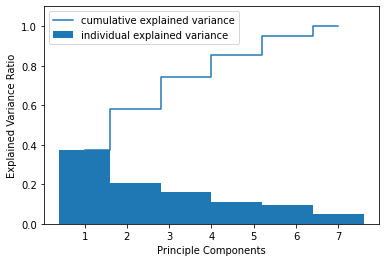

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=X.shape[1])
pca.fit(X)

pca.explained_variance_ratio_
cum_var = np.cumsum(pca.explained_variance_ratio_)
mp.bar(np.linspace(1,X.shape[1]+1,X.shape[1]), pca.explained_variance_ratio_, width=1.2, align='center', label='individual explained variance')
mp.step(np.linspace(1,X.shape[1]+1,X.shape[1]), cum_var, where='mid', label='cumulative explained variance')
mp.ylabel('Explained Variance Ratio')
mp.xlabel('Principle Components')
mp.legend(loc='best')
mp.ylim([0, 1.1])
cum_var

In [45]:
scores = []
for i in range(1,X.shape[1]+1):
    pca = PCA(n_components=i)
    feat_pca = pca.fit_transform(X)
    params_cv = {'kernel':['linear', 'rbf'], 'C':[1, 3, 5, 10], 'degree':[3, 5, 10]}
    grid = GridSearchCV(SVC(), params_cv, cv=5)
    grid.fit(feat_pca, y)
    scores.append(grid.best_score_)

print(scores)

[0.6434644957033017, 0.7156490275893261, 0.7395748530076889, 0.7395296246042514, 0.7484848484848484, 0.7423337856173677]


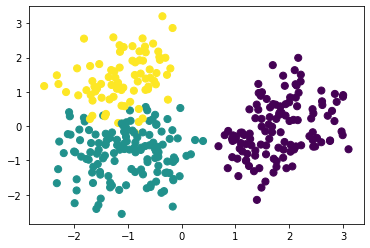

In [46]:
pca = PCA(n_components=2)
feat_pca = pca.fit_transform(X)
pca_test = pca.transform(test_data_after_cl)
svc_b = SVC(C = 3, degree = 3, kernel = 'rbf', probability = True, random_state = 0)
svc_b.fit(feat_pca, y)
y_pred = svc_b.predict(pca_test)
# y_pred = svc_b.predict(test_data_after_cl)



plt.scatter(feat_pca[:,0], feat_pca[:,1], c=kmeans.labels_, s=50, cmap='viridis')



In [47]:
submission = pd.DataFrame({'id':test_data_orig['id'], 'type':y_pred})

submission['type'] = le.inverse_transform(submission['type'])
submission.to_csv('../working/submission.csv', index=False)